In [ ]:
!pip install qiskit #qiskitのインストール 

In [ ]:
#ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
from qiskit import Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import QasmSimulator
#from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram

$$ f(x,y)=(x ∨ y) ∧ (¬ x ∨ y) ∧ (¬x ∨ ¬ y) $$ の2-SAT問題を解くグローバーのアルゴリズムの実装例を以下に示す。この論理式を充足する解は $$ x = False , y = True$$のときのみである。


In [ ]:
#リテラルの値を記憶する量子ビットにアダマール変換を施す
def Hadamard(qc):
  for i in range(2):
    qc.h(i)
  return qc

In [ ]:
#回路の初期化
def initial_circuit():
  qc = QuantumCircuit(6,2) #量子ビットは2変数、3つの節、符号反転で使う1量子ビットの合わせて6ビット使う。古典ビットは測定する量子ビットの数
  qc = Hadamard(qc)
  initial_state = [0,1]   # 初期状態を|1>と定義
  qc.initialize(initial_state, 5) # 初期化操作を符号反転用の6番目の量子ビットに適用。
  qc.h(5) # 6番目の量子は|->状態になる。
  return qc

In [ ]:
circuit = initial_circuit()
circuit.draw() #回路の図示

┌───┐            
q_0: ───────┤ H ├────────────
            ├───┤            
q_1: ───────┤ H ├────────────
            └───┘            
q_2: ────────────────────────
                             
q_3: ────────────────────────
                             
q_4: ────────────────────────
     ┌─────────────────┐┌───┐
q_5: ┤ Initialize(0,1) ├┤ H ├
     └─────────────────┘└───┘
c: 2/════════════════════════

In [ ]:
#オラクルのゲート

def Oracle(qc):
  #1つめの節
    qc.x(0)
    qc.x(1)
    qc.mcx([0,1],2) 
    qc.x(0)
    qc.x(1)
  
  #2つめの節
    qc.x(1)
    qc.mcx([0,1],3) 
    qc.x(1)
  
  #3つめの節
    qc.mcx([0,1],4)

  #3つの条件を同時に満たすかを判定
    qc.x(2)
    qc.x(3)
    qc.x(4)
    qc.mcx([2,3,4],5) 
    qc.x(2)
    qc.x(3)
    qc.x(4)

  #補助ビットを0にリセットするために3番目の節から逆順にゲートをかける

  #3つめの節
    qc.mcx([0,1],4)
  
  #2つめの節
    qc.x(1)
    qc.mcx([0,1],3) 
    qc.x(1)

  #1つめの節
    qc.x(0)
    qc.x(1)
    qc.mcx([0,1],2) 
    qc.x(0)
    qc.x(1)
  
    return qc

In [ ]:
circuit = Oracle(circuit)
circuit.draw() #回路の図示

┌───┐       ┌───┐     ┌───┐                                        »
q_0: ───────┤ H ├───────┤ X ├──■──┤ X ├───────■─────────■───────────────────■──»
            ├───┤       ├───┤  │  ├───┤┌───┐  │  ┌───┐  │                   │  »
q_1: ───────┤ H ├───────┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■───────────────────■──»
            └───┘       └───┘┌─┴─┐├───┤└───┘  │  └───┘  │            ┌───┐  │  »
q_2: ────────────────────────┤ X ├┤ X ├───────┼─────────┼─────────■──┤ X ├──┼──»
                             └───┘└───┘     ┌─┴─┐┌───┐  │         │  ├───┤  │  »
q_3: ───────────────────────────────────────┤ X ├┤ X ├──┼─────────■──┤ X ├──┼──»
                                            └───┘└───┘┌─┴─┐┌───┐  │  ├───┤┌─┴─┐»
q_4: ─────────────────────────────────────────────────┤ X ├┤ X ├──■──┤ X ├┤ X ├»
     ┌─────────────────┐┌───┐                         └───┘└───┘┌─┴─┐└───┘└───┘»
q_5: ┤ Initialize(0,1) ├┤ H ├───────────────────────────────────┤ X ├──────────»
     └─────────────────┘└───┘                                   └───┘          »
c: 2/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«               ┌───┐          ┌───┐
«q_0: ───────■──┤ X ├───────■──┤ X ├
«     ┌───┐  │  ├───┤┌───┐  │  ├───┤
«q_1: ┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├
«     └───┘  │  └───┘└───┘┌─┴─┐└───┘
«q_2: ───────┼────────────┤ X ├─────
«          ┌─┴─┐          └───┘     
«q_3: ─────┤ X ├────────────────────
«          └───┘                    
«q_4: ──────────────────────────────
«                                   
«q_5: ──────────────────────────────
«                                   
«c: 2/══════════════════════════════
«

In [ ]:
#Diffuserの作成

def Diffuser(qc):

  qc = Hadamard(qc)

  qc.x(0)
  qc.x(1)
  qc.mcx([0,1],5) 
  qc.x(0)
  qc.x(1)

  qc = Hadamard(qc)
  
  return qc

In [ ]:
circuit = Diffuser(circuit)
circuit.draw() #回路の図示

┌───┐       ┌───┐     ┌───┐                                        »
q_0: ───────┤ H ├───────┤ X ├──■──┤ X ├───────■─────────■───────────────────■──»
            ├───┤       ├───┤  │  ├───┤┌───┐  │  ┌───┐  │                   │  »
q_1: ───────┤ H ├───────┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■───────────────────■──»
            └───┘       └───┘┌─┴─┐├───┤└───┘  │  └───┘  │            ┌───┐  │  »
q_2: ────────────────────────┤ X ├┤ X ├───────┼─────────┼─────────■──┤ X ├──┼──»
                             └───┘└───┘     ┌─┴─┐┌───┐  │         │  ├───┤  │  »
q_3: ───────────────────────────────────────┤ X ├┤ X ├──┼─────────■──┤ X ├──┼──»
                                            └───┘└───┘┌─┴─┐┌───┐  │  ├───┤┌─┴─┐»
q_4: ─────────────────────────────────────────────────┤ X ├┤ X ├──■──┤ X ├┤ X ├»
     ┌─────────────────┐┌───┐                         └───┘└───┘┌─┴─┐└───┘└───┘»
q_5: ┤ Initialize(0,1) ├┤ H ├───────────────────────────────────┤ X ├──────────»
     └─────────────────┘└───┘                                   └───┘          »
c: 2/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«               ┌───┐          ┌───┐┌───┐┌───┐     ┌───┐┌───┐
«q_0: ───────■──┤ X ├───────■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├
«     ┌───┐  │  ├───┤┌───┐  │  ├───┤├───┤├───┤  │  ├───┤├───┤
«q_1: ┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├
«     └───┘  │  └───┘└───┘┌─┴─┐└───┘└───┘└───┘  │  └───┘└───┘
«q_2: ───────┼────────────┤ X ├─────────────────┼────────────
«          ┌─┴─┐          └───┘                 │            
«q_3: ─────┤ X ├────────────────────────────────┼────────────
«          └───┘                                │            
«q_4: ──────────────────────────────────────────┼────────────
«                                             ┌─┴─┐          
«q_5: ────────────────────────────────────────┤ X ├──────────
«                                             └───┘          
«c: 2/═══════════════════════════════════════════════════════
«

In [ ]:
#測定のコード

def Measure(qc):
  qc.measure([0,1],[0,1]) #0と1番目の量子ビットを測定し、その結果を0と1番目の古典ビットに記憶させる
  simulator = QasmSimulator()
  compiled_circuit = transpile(qc, simulator)
  job = simulator.run(compiled_circuit, shots=5000) #shotsの数だけ測定
  result = job.result()
  counts = result.get_counts(qc)
  return counts
  

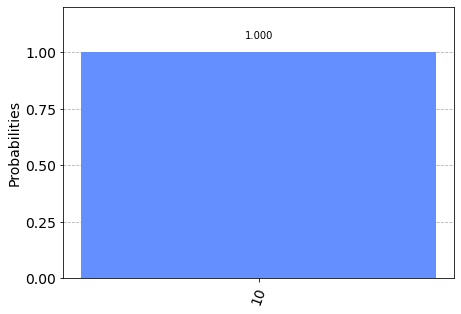

In [ ]:
 counts = Measure(circuit)
 plot_histogram(counts) #ヒストグラムで結果を表示
 # x = F , y = Tを表す

In [ ]:
 circuit.draw()

┌───┐       ┌───┐     ┌───┐                                        »
q_0: ───────┤ H ├───────┤ X ├──■──┤ X ├───────■─────────■───────────────────■──»
            ├───┤       ├───┤  │  ├───┤┌───┐  │  ┌───┐  │                   │  »
q_1: ───────┤ H ├───────┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■───────────────────■──»
            └───┘       └───┘┌─┴─┐├───┤└───┘  │  └───┘  │            ┌───┐  │  »
q_2: ────────────────────────┤ X ├┤ X ├───────┼─────────┼─────────■──┤ X ├──┼──»
                             └───┘└───┘     ┌─┴─┐┌───┐  │         │  ├───┤  │  »
q_3: ───────────────────────────────────────┤ X ├┤ X ├──┼─────────■──┤ X ├──┼──»
                                            └───┘└───┘┌─┴─┐┌───┐  │  ├───┤┌─┴─┐»
q_4: ─────────────────────────────────────────────────┤ X ├┤ X ├──■──┤ X ├┤ X ├»
     ┌─────────────────┐┌───┐                         └───┘└───┘┌─┴─┐└───┘└───┘»
q_5: ┤ Initialize(0,1) ├┤ H ├───────────────────────────────────┤ X ├──────────»
     └─────────────────┘└───┘                                   └───┘          »
c: 2/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«               ┌───┐          ┌───┐┌───┐┌───┐     ┌───┐┌───┐┌─┐   
«q_0: ───────■──┤ X ├───────■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├┤M├───
«     ┌───┐  │  ├───┤┌───┐  │  ├───┤├───┤├───┤  │  ├───┤├───┤└╥┘┌─┐
«q_1: ┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─╫─┤M├
«     └───┘  │  └───┘└───┘┌─┴─┐└───┘└───┘└───┘  │  └───┘└───┘ ║ └╥┘
«q_2: ───────┼────────────┤ X ├─────────────────┼─────────────╫──╫─
«          ┌─┴─┐          └───┘                 │             ║  ║ 
«q_3: ─────┤ X ├────────────────────────────────┼─────────────╫──╫─
«          └───┘                                │             ║  ║ 
«q_4: ──────────────────────────────────────────┼─────────────╫──╫─
«                                             ┌─┴─┐           ║  ║ 
«q_5: ────────────────────────────────────────┤ X ├───────────╫──╫─
«                                             └───┘           ║  ║ 
«c: 2/════════════════════════════════════════════════════════╩══╩═
«                                                             0  1

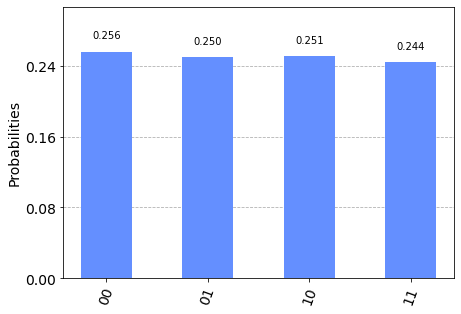

In [ ]:
#初期状態の確率分布
circuit = initial_circuit()

counts = Measure(circuit)
plot_histogram(counts)

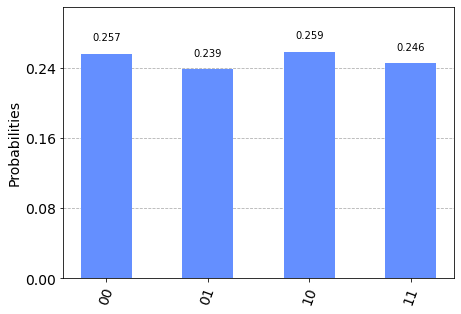

In [ ]:
n = 2 #オラクルとDiffuserの繰り返し回数 ２回
circuit = initial_circuit()

for i in range(n):
   circuit = Oracle(circuit)
   circuit = Diffuser(circuit)

counts = Measure(circuit)
plot_histogram(counts)

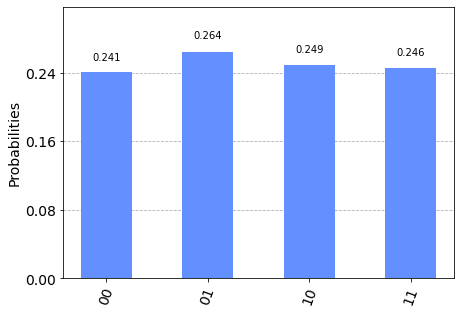

In [ ]:
n = 3 #オラクルとDiffuserの繰り返し回数 3回
circuit = initial_circuit()

for i in range(n):
   circuit = Oracle(circuit)
   circuit = Diffuser(circuit)

counts = Measure(circuit)
plot_histogram(counts)

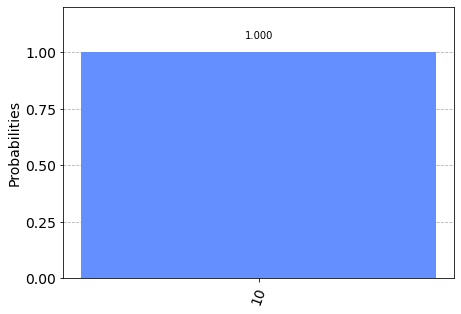

In [ ]:
n = 4 #オラクルとDiffuserの繰り返し回数 4回
circuit = initial_circuit()

for i in range(n):
   circuit = Oracle(circuit)
   circuit = Diffuser(circuit)

counts = Measure(circuit)
plot_histogram(counts)

#今回の場合は1回,4回,7回．．．のとき正しい答えを返す。

In [ ]:
 circuit.draw()

┌───┐       ┌───┐     ┌───┐                                        »
q_0: ───────┤ H ├───────┤ X ├──■──┤ X ├───────■─────────■───────────────────■──»
            ├───┤       ├───┤  │  ├───┤┌───┐  │  ┌───┐  │                   │  »
q_1: ───────┤ H ├───────┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■───────────────────■──»
            └───┘       └───┘┌─┴─┐├───┤└───┘  │  └───┘  │            ┌───┐  │  »
q_2: ────────────────────────┤ X ├┤ X ├───────┼─────────┼─────────■──┤ X ├──┼──»
                             └───┘└───┘     ┌─┴─┐┌───┐  │         │  ├───┤  │  »
q_3: ───────────────────────────────────────┤ X ├┤ X ├──┼─────────■──┤ X ├──┼──»
                                            └───┘└───┘┌─┴─┐┌───┐  │  ├───┤┌─┴─┐»
q_4: ─────────────────────────────────────────────────┤ X ├┤ X ├──■──┤ X ├┤ X ├»
     ┌─────────────────┐┌───┐                         └───┘└───┘┌─┴─┐└───┘└───┘»
q_5: ┤ Initialize(0,1) ├┤ H ├───────────────────────────────────┤ X ├──────────»
     └─────────────────┘└───┘                                   └───┘          »
c: 2/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«               ┌───┐          ┌───┐┌───┐┌───┐     ┌───┐┌───┐┌───┐     ┌───┐»
«q_0: ───────■──┤ X ├───────■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├»
«     ┌───┐  │  ├───┤┌───┐  │  ├───┤├───┤├───┤  │  ├───┤├───┤├───┤  │  ├───┤»
«q_1: ┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├»
«     └───┘  │  └───┘└───┘┌─┴─┐└───┘└───┘└───┘  │  └───┘└───┘└───┘┌─┴─┐├───┤»
«q_2: ───────┼────────────┤ X ├─────────────────┼─────────────────┤ X ├┤ X ├»
«          ┌─┴─┐          └───┘                 │                 └───┘└───┘»
«q_3: ─────┤ X ├────────────────────────────────┼───────────────────────────»
«          └───┘                                │                           »
«q_4: ──────────────────────────────────────────┼───────────────────────────»
«                                             ┌─┴─┐                         »
«q_5: ────────────────────────────────────────┤ X ├─────────────────────────»
«                                             └───┘                         »
«c: 2/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                       ┌───┐          ┌───┐»
«q_0: ───────■─────────■───────────────────■─────────■──┤ X ├───────■──┤ X ├»
«     ┌───┐  │  ┌───┐  │                   │  ┌───┐  │  ├───┤┌───┐  │  ├───┤»
«q_1: ┤ X ├──■──┤ X ├──■───────────────────■──┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├»
«     └───┘  │  └───┘  │            ┌───┐  │  └───┘  │  └───┘└───┘┌─┴─┐└───┘»
«q_2: ───────┼─────────┼─────────■──┤ X ├──┼─────────┼────────────┤ X ├─────»
«          ┌─┴─┐┌───┐  │         │  ├───┤  │       ┌─┴─┐          └───┘     »
«q_3: ─────┤ X ├┤ X ├──┼─────────■──┤ X ├──┼───────┤ X ├────────────────────»
«          └───┘└───┘┌─┴─┐┌───┐  │  ├───┤┌─┴─┐     └───┘                    »
«q_4: ───────────────┤ X ├┤ X ├──■──┤ X ├┤ X ├──────────────────────────────»
«                    └───┘└───┘┌─┴─┐└───┘└───┘                              »
«q_5: ─────────────────────────┤ X ├────────────────────────────────────────»
«                              └───┘                                        »
«c: 2/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«     ┌───┐┌───┐     ┌───┐┌───┐┌───┐     ┌───┐                              »
«q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├───────■─────────■────────────»
«     ├───┤├───┤  │  ├───┤├───┤├───┤  │  ├───┤┌───┐  │  ┌───┐  │            »
«q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■────────────»
«     └───┘└───┘  │  └───┘└───┘└───┘┌─┴─┐├───┤└───┘  │  └───┘  │            »
«q_2: ────────────┼─────────────────┤ X ├┤ X ├───────┼─────────┼───